<a href="https://colab.research.google.com/github/reembk5/reem-ML/blob/main/task_A_REEM_177645.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
files are being loaded...
loaded successfully


/tmp/ipython-input-2497191756.py:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=missing_data.index,y=missing_data.values,palette = 'viridis')


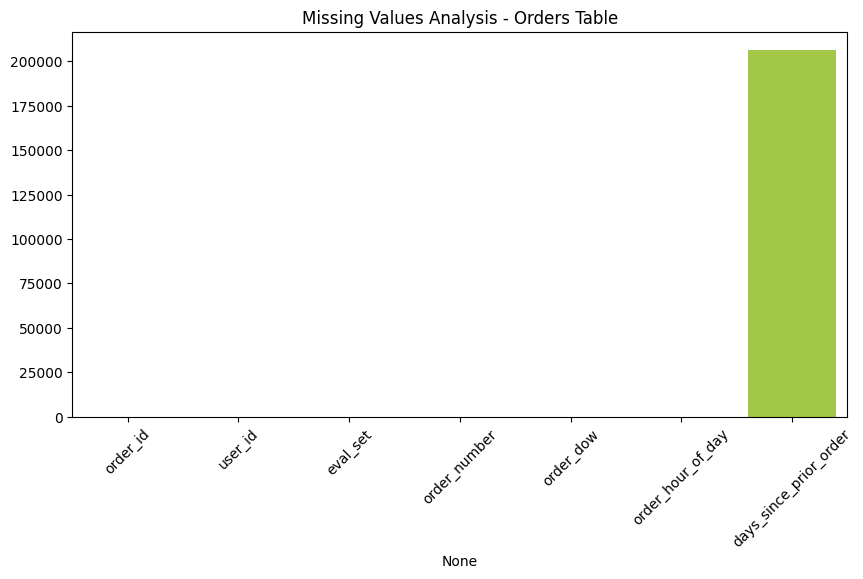

the code has run ... the plot is now displayed


In [ ]:
# Importing some libraries (data ingestion)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
#تفعيل الوصول لملفات قوقل درايف
from google.colab import drive
drive.mount('/content/drive')

#تحديد المسار للملف
path = '/content/drive/MyDrive/Instacart_Project_MMMMLLLLL/'
#تقليل الذاكرة بدنا نعمل memory savvy عشان نصغر حجمالبيانات
def reduce_mem_usage(df):
    for col in df.columns:
        if df[col].dtype == 'int64':
             df[col] = pd.to_numeric(df[col],
downcast='integer')
        elif df[col].dtype == 'float64':
                                         df[col] = pd.to_numeric(df[col],
downcast = 'float')
    return df
#تحميل الملفات
print("files are being loaded...")
orders = reduce_mem_usage(pd.read_csv(path + 'orders.csv'))
products = reduce_mem_usage(pd.read_csv(path + 'products.csv'))
aisles = reduce_mem_usage(pd.read_csv(path + 'aisles.csv'))
departments = reduce_mem_usage(pd.read_csv(path + "departments.csv"))
print("loaded successfully")
#تحليل القيم المفقودة و رسمها EDA
missing_data = orders.isnull().sum()

plt.figure(figsize=(10 , 5))
sns.barplot(x=missing_data.index,y=missing_data.values,palette = 'viridis')
plt.title('Missing Values Analysis - Orders Table')
plt.xticks(rotation=45)
plt.savefig('missing_values_plot.png')
plt.show()
print("the code has run ... the plot is now displayed")
#هون خلصت اول اشي انطلب و هو EDA --> EDA
#الان نبدا ب heavy preprocessing :
# join :
products_full = pd.merge(products,
aisles , on='aisle_id', how='left')
products_full = pd.merge(products_full, departments , on='department_id' , how='left' )

In [ ]:
# 3 هسه بدي اعمل تحليل للقيم المفقودة ,لاحظنا انه طلع معنا اكثر من 200 الف قيمة مفقودة عشان هيك يلا نبدأ define and justify imputatiom
orders['days_since_prior_order'] = orders['days_since_prior_order'].fillna(0) #--> هون عوضت القيم المفقودة في عمود الايام منذ الطلب السابق ب 0
print(orders.isnull().sum())#--> عشان اتأكد هل القيم المفقودة اختفت ؟؟

order_id                  0
user_id                   0
eval_set                  0
order_number              0
order_dow                 0
order_hour_of_day         0
days_since_prior_order    0
dtype: int64


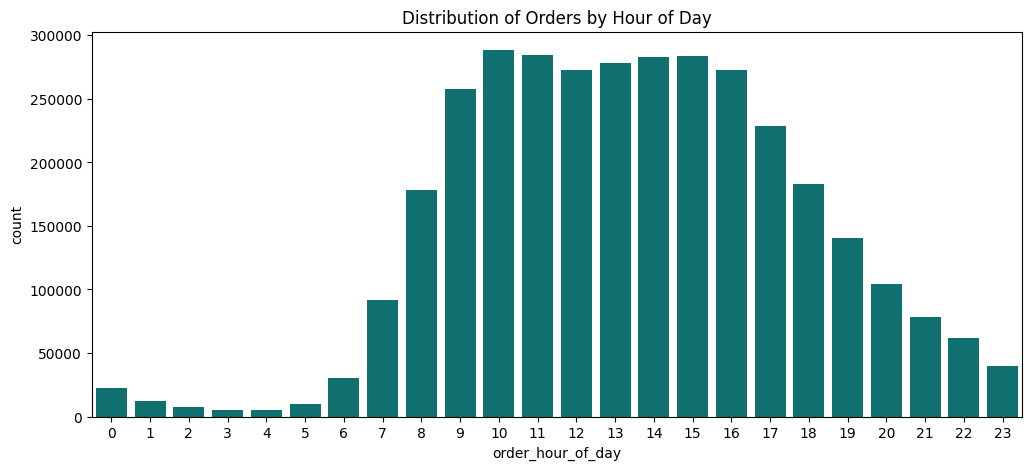

In [ ]:
#3هسه بدنا نوزع الطلبات حسب ساعة اليوم
plt.figure(figsize=(12,5))
sns.countplot(data=orders,x='order_hour_of_day' , color='teal')
plt.title('Distribution of Orders by Hour of Day')
plt.show()

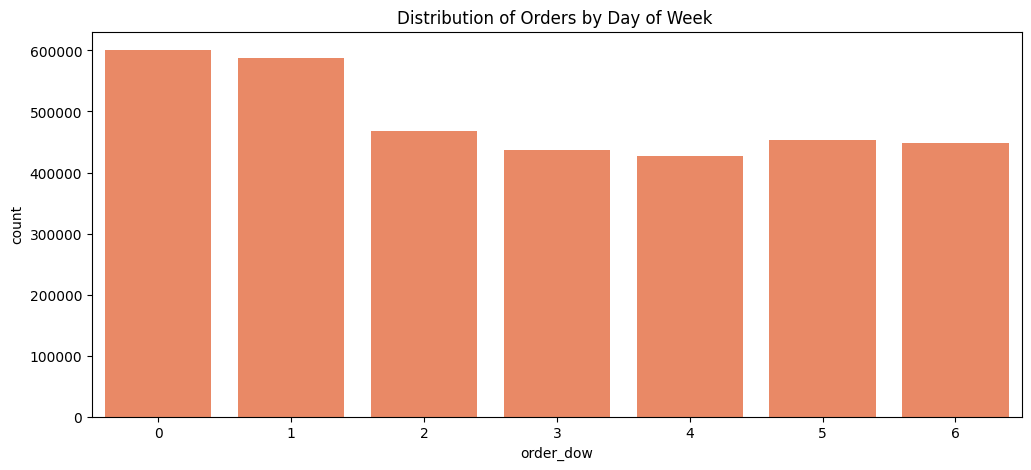

In [ ]:
#3هسه نوزع الطلبات حسب يوم الاسبوع
plt.figure(figsize=(12,5))
sns.countplot(data=orders,x='order_dow' , color='coral')
plt.title('Distribution of Orders by Day of Week ')
plt.show()

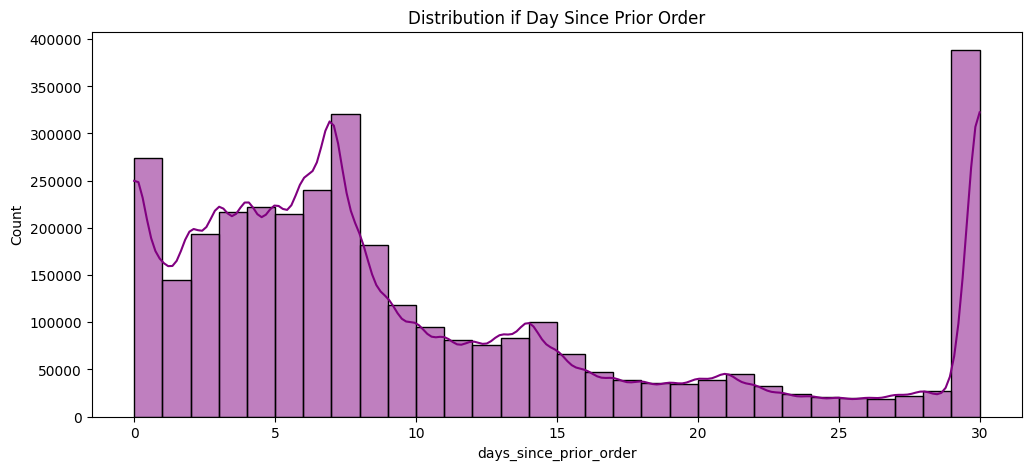

In [ ]:
#3هسه بدنا نعمل تحليل لعد الايام , بما انه اكتشفنا قيم مفقود لازم نرسم التوزيع عشان نعالج
plt.figure(figsize=(12,5))
sns.histplot(orders['days_since_prior_order'].dropna(), bins=30, kde=True , color= 'purple')
plt.title('Distribution if Day Since Prior Order')
plt.show()

In [ ]:
# Encoding Categorical Variabls
# نبدأ الان خطوة 4
#بهاي الخوة بدنا نجهز لغة الارقام للموديل و حسب ملف الفاينل بروجطت في ثلاث استراتيجيات لمختلفة لازم نعملهم للترميز
#الاستراتيجية الاولى : (One-Hot Encoding OHE) ----> هاي الطريقة مناسبة للفئات الي ما الهم خيارات كثير يعني هم (low-cardinality)--> نطبقها على ايام الاسبوع
#ليه ؟ عشان نحول ايام الاسبوع الى عمدة منفصلة
orders_ohe = pd.get_dummies(orders,columns=['order_dow'], prefix='day')
print(orders_ohe.head())

   order_id  user_id eval_set  order_number  order_hour_of_day  \
0   2539329        1    prior             1                  8   
1   2398795        1    prior             2                  7   
2    473747        1    prior             3                 12   
3   2254736        1    prior             4                  7   
4    431534        1    prior             5                 15   

   days_since_prior_order  day_0  day_1  day_2  day_3  day_4  day_5  day_6  
0                     0.0  False  False   True  False  False  False  False  
1                    15.0  False  False  False   True  False  False  False  
2                    21.0  False  False  False   True  False  False  False  
3                    29.0  False  False  False  False   True  False  False  
4                    28.0  False  False  False  False   True  False  False  


In [ ]:
#الاستراتيجية الثانية : (Frequency Encoding) --> هاي الطريقة للاعمدة الي تحتوي على خيارات كثيرة مثلا زي اسماء الاقسام ليه طيب مناسبة ؟ لانها تستبدل الاسم بنسبة تكراره قي البيانات
dept_freq = products_full['department'].value_counts(normalize= True)
products_full['dept_freq_enc'] = products_full['department'].map(dept_freq)
print(products_full[['department','dept_freq_enc']].head())

  department  dept_freq_enc
0     snacks       0.126067
1     pantry       0.108095
2  beverages       0.087848
3     frozen       0.080643
4     pantry       0.108095


In [ ]:
#الاستراتيجية الثالثة : Target/Mean Encoding ----->  هاي الطريقة حلوة لانه نحول الصنف الى رقم بناءا على متوسط الهدف مثلا كم مرة تم اعادة شراء هذا المنتج بالمتوسط ولكننننن عشان رح يصير عندنا تسريب للبيانات (leakage) -> يفضل استخدامها لاحقا لما نربط بيانات التدريب بالهدف
#توضيح بسيط :عشان نتفادى تسريب البيانات نقدر نعمل (k-fold) & (smoothing) --> و لكن رح نعملهم بعد خطوة 6 عشان احنا بنحتاج target يكون مربوط مع ال features

In [ ]:
from pandas.io import clipboards
# خطوة 5
from sklearn.preprocessing import StandardScaler
#تعريف scaler
scaler = StandardScaler()
#تحديد الاعمدة الرقمية الي بدنا نعمل الها scaling
'order_number' , 'order_dow' , 'order_hour_of_day','days_since_prior_order'
cols_to_scale = ['order_number','order_dow','order_hour_of_day','days_since_prior_order']
#تطبيق ال scaling
orders[cols_to_scale] = scaler.fit_transform(orders[cols_to_scale])
#نعرض النتيجة عشان نشوف انو الارقام صارت متقاربةو صغنونة ؟؟
print(orders[cols_to_scale].head())



   order_number  order_dow  order_hour_of_day  days_since_prior_order
0     -0.910997  -0.379230          -1.290086               -1.122053
1     -0.854605   0.109331          -1.526711                0.489339
2     -0.798214   0.109331          -0.343584                1.133896
3     -0.741822   0.597891          -1.526711                1.993304
4     -0.685431   0.597891           0.366293                1.885878


In [ ]:
#6
path = '/content/drive/MyDrive/Instacart_Project_MMMMLLLLL/'
orders = pd.read_csv(path + 'orders.csv')
prior = pd.read_csv(path + 'order_products__prior.csv')
user_features = orders.groupby('user_id').agg(total_orders=('order_number','max'),mean_days_between=('days_since_prior_order','mean')).reset_index()
merged_prior = pd.merge(prior,orders,on = 'order_id',how = 'left')
user_reorder_ratio = merged_prior.groupby('user_id')['reordered'].mean().reset_index()
user_reorder_ratio.columns = ['user_id' ,'user_reorder_ratio']
user_features = pd.merge(user_features , user_reorder_ratio , on = 'user_id', how = 'left')
print("done user features ")
user_features.head()

done user features 


,user_id,total_orders,mean_days_between,user_reorder_ratio
0,1,11,19.000000,0.694915
1,2,15,16.285714,0.476923
2,3,13,12.000000,0.625000
3,4,6,17.000000,0.055556
4,5,5,11.500000,0.378378


doneee
Index(['user_id', 'total_orders', 'mean_days_between', 'user_reorder_ratio'], dtype='object')


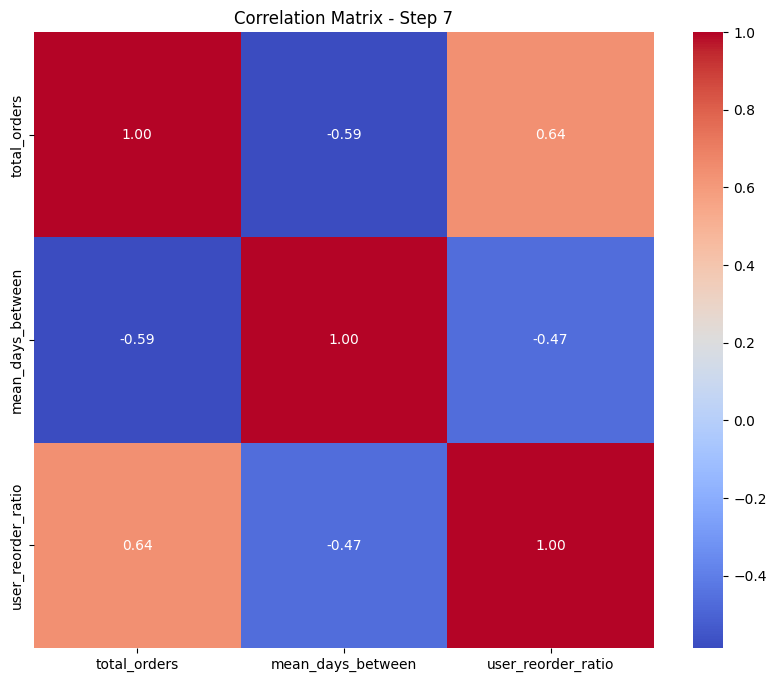

yse 


In [ ]:
#7 بهاي الخطوة بدنا نشوف هل ال (features) الي عملناها هل هي متكررة او لا
user_features = orders.groupby('user_id').agg(total_orders=('order_number','max'),mean_days_between=('days_since_prior_order','mean')).reset_index()
user_reorder_ratio = merged_prior.groupby('user_id')['reordered'].mean().reset_index()
user_reorder_ratio.columns = ['user_id', 'user_reorder_ratio']
final_df = pd.merge(user_features, user_reorder_ratio, on='user_id', how='left')
print("doneee")
print(final_df.columns)
import seaborn as sns
import matplotlib.pyplot as plt
cols_to_corr = ['total_orders', 'mean_days_between', 'user_reorder_ratio']
corr_matrix = final_df[cols_to_corr].corr()
plt.figure(figsize=(10,8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix - Step 7')
plt.show()
print("yse ")






thlel
user_reorder_ratio
1    83.697123
0    16.302877
Name: proportion, dtype: float64


/tmp/ipython-input-340650465.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=temp_target, palette='viridis')


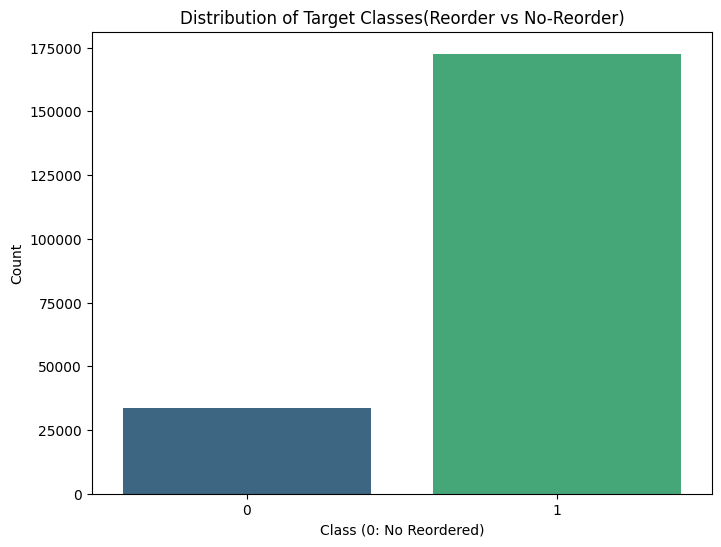

Note : SMOT and class weight will be applied during the model phase(step10-13)to compare results  


In [ ]:
#8
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE #--> مكتبة التعامل مع عد التوازن
if 'user_reorder_ratio' in final_df.columns:
  temp_target = final_df['user_reorder_ratio'].apply(lambda x: 1 if x > 0.2 else 0)
  print("thlel")
  print(temp_target.value_counts(normalize=True) * 100)
  plt.figure(figsize=(8, 6))
  sns.countplot(x=temp_target, palette='viridis')
  plt.title('Distribution of Target Classes(Reorder vs No-Reorder)')
  plt.xlabel('Class (0: No Reordered)')
  plt.ylabel('Count')
  plt.show()
  print("Note : SMOT and class weight will be applied during the model phase(step10-13)to compare results  ")



In [ ]:
from matplotlib import axis
from typing_extensions import final
#9
final_df = final_df.sort_values(['user_id' , 'total_orders'])
train_data = final_df[final_df['total_orders'] < final_df['total_orders'].max()]
test_data = final_df[final_df['total_orders'] == final_df['total_orders'].max()]
X_train = train_data.drop(['user_id'], axis=1)
y_train = train_data['user_reorder_ratio'].apply(lambda x: 1 if x>0.2 else 0)
X_test = test_data.drop(['user_id'], axis=1)
y_test = test_data['user_reorder_ratio'].apply(lambda x: 1 if x > 0.2 else 0)
print(f"Train set size: {X_train.shape}")
print(f"Test set size : {X_test.shape}")
print("the data was split based on chronological order to ensure no data leakage")



Train set size: (204835, 3)
Test set size : (1374, 3)
the data was split based on chronological order to ensure no data leakage


In [ ]:
#تحضير الجداول الطلوبة لtask A
user_product_features = merged_prior.groupby(['user_id', 'product_id']).agg(up_order_count=('order_id', 'count'), up_reorder_ratio=('reordered', 'mean')).reset_index()
#انشاء ميزات المنتج prodouct-level features
product_features = prior.groupby('product_id').agg(prod_reorder_rate=('reordered', 'mean'), prod_avg_pos=('add_to_cart_order', 'mean')).reset_index()


In [ ]:
# --- TASK (A) - التجهيز مع تصغير حجم البيانات ---

# 1. دمج الميزات (كما فعلنا سابقاً)
df_task_a = pd.merge(user_product_features, user_features, on='user_id', how='left')
df_task_a = pd.merge(df_task_a, product_features, on='product_id', how='left')

# 2. تقليل حجم البيانات (Sampling)
# هون رح ناخذ 100 ألف سطر فقط، هاد العدد كافي جداً للتدريب وما بيفجر الرام
df_task_a = df_task_a.sample(n=100000, random_state=42) if len(df_task_a) > 100000 else df_task_a

# 3. تحديد الهدف والميزات
y = (df_task_a['up_order_count'] > 1).astype(int)
cols_to_drop = ['user_id', 'product_id', 'up_order_count', 'up_reorder_ratio']
X = df_task_a.drop(columns=[c for c in cols_to_drop if c in df_task_a.columns])

# 4. التقسيم (بما أننا عملنا sample، الـ shuffle=True صار أفضل لضمان توزيع البيانات)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"✅ تم تجهيز عينة من {X.shape[0]} سطر.")
print("الآن الرام رح تكون مرتاحة والتدريب سريع!")

✅ تم تجهيز عينة من 100000 سطر.
الآن الرام رح تكون مرتاحة والتدريب سريع!


In [ ]:
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, roc_auc_score, matthews_corrcoef,
                             confusion_matrix, classification_report)
import seaborn as sns
import matplotlib.pyplot as plt

def evaluate_classification_model(model, X_test, y_test, model_name):
    # التوقعات
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else None

    # حساب المقاييس المطلوبة في الملف
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    mcc = matthews_corrcoef(y_test, y_pred) # مطلوب في صفحة 3
    auc = roc_auc_score(y_test, y_prob) if y_prob is not None else "N/A"

    print(f"\n======= [ {model_name} Evaluation ] =======")
    print(f"Accuracy:  {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall:    {rec:.4f}")
    print(f"F1-Score:  {f1:.4f}")
    print(f"MCC:       {mcc:.4f} (Robust Metric)")
    print(f"AUC-ROC:   {auc:.4f}" if isinstance(auc, float) else f"AUC-ROC: {auc}")

    # رسم الـ Confusion Matrix (لتحليل الـ TP, TN, FP, FN)
    plt.figure(figsize=(4,3))
    sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Greens')
    plt.title(f'Confusion Matrix: {model_name}')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

    return {"Model": model_name, "Accuracy": acc, "F1": f1, "MCC": mcc, "AUC": auc}

بدء تدريب وتقييم الموديلات... (قد يستغرق ذلك دقائق قليلة)
جاري معالجة: Logistic Regression...

======= [ Logistic Regression Evaluation ] =======
Accuracy:  0.6275
Precision: 0.5274
Recall:    0.6635
F1-Score:  0.5877
MCC:       0.2616 (Robust Metric)
AUC-ROC:   0.6859


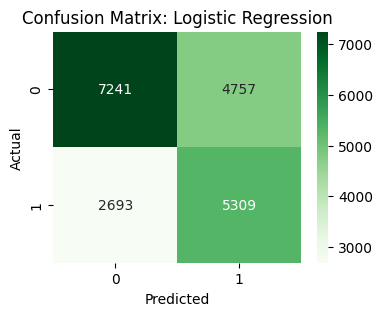

جاري معالجة: KNN (N=5)...

======= [ KNN (N=5) Evaluation ] =======
Accuracy:  0.5881
Precision: 0.4832
Recall:    0.4228
F1-Score:  0.4510
MCC:       0.1245 (Robust Metric)
AUC-ROC:   0.5895


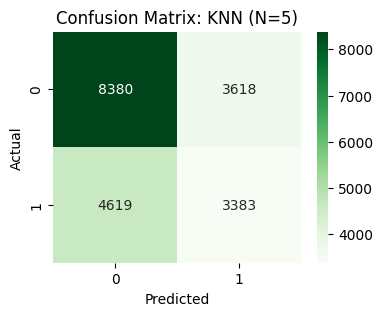

جاري معالجة: Decision Tree...

======= [ Decision Tree Evaluation ] =======
Accuracy:  0.6190
Precision: 0.5182
Recall:    0.6803
F1-Score:  0.5883
MCC:       0.2536 (Robust Metric)
AUC-ROC:   0.6739


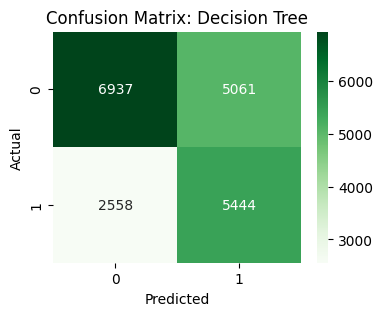

جاري معالجة: Random Forest...

======= [ Random Forest Evaluation ] =======
Accuracy:  0.6302
Precision: 0.5304
Recall:    0.6618
F1-Score:  0.5889
MCC:       0.2656 (Robust Metric)
AUC-ROC:   0.6904


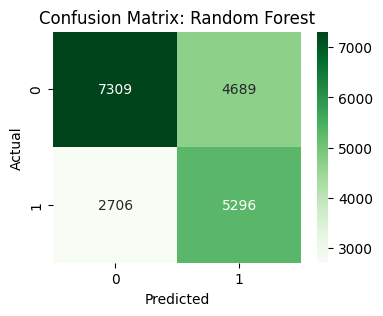

جاري معالجة: XGBoost...

======= [ XGBoost Evaluation ] =======
Accuracy:  0.6517
Precision: 0.5891
Recall:    0.4281
F1-Score:  0.4959
MCC:       0.2470 (Robust Metric)
AUC-ROC:   0.6855


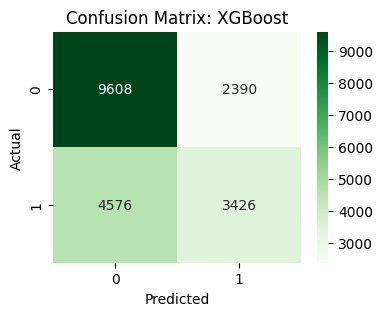

جاري معالجة: SVM (Linear)...


/usr/local/lib/python3.12/dist-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(



======= [ SVM (Linear) Evaluation ] =======
Accuracy:  0.6081
Precision: 0.5241
Recall:    0.2239
F1-Score:  0.3138
MCC:       0.1150 (Robust Metric)
AUC-ROC:   0.5971


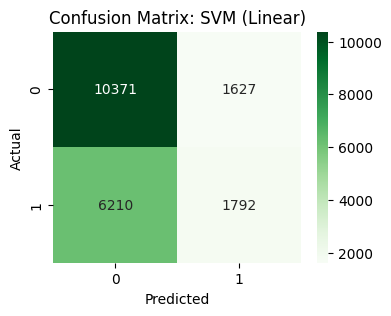


======= ملخص مقارنة جميع موديلات Task A =======
                 Model  Accuracy        F1       MCC       AUC
3        Random Forest   0.63025  0.588870  0.265555  0.690431
0  Logistic Regression   0.62750  0.587669  0.261599  0.685855
4              XGBoost   0.65170  0.495875  0.246984  0.685530
2        Decision Tree   0.61905  0.588318  0.253621  0.673866
5         SVM (Linear)   0.60815  0.313808  0.114960  0.597078
1            KNN (N=5)   0.58815  0.450976  0.124506  0.589512


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import pandas as pd

# 1. تعريف الموديلات الستة المطلوبة في المشروع
models = {
    "Logistic Regression": LogisticRegression(class_weight='balanced', max_iter=1000),
    "KNN (N=5)": KNeighborsClassifier(n_neighbors=5),
    "Decision Tree": DecisionTreeClassifier(max_depth=10, class_weight='balanced'),
    # تم تقليل n_estimators لـ RF و XGB لضمان السرعة مع الرام
    "Random Forest": RandomForestClassifier(n_estimators=50, max_depth=10, class_weight='balanced', n_jobs=-1),
    "XGBoost": XGBClassifier(n_estimators=50, max_depth=6, eval_metric='logloss'),
    # الـ SVM ثقيل جداً، سنستخدم عينة أصغر له أو LinearSVC لضمان عدم توقف الجهاز
    "SVM (Linear)": SVC(kernel='linear', probability=True, max_iter=500)
}

# قائمة لتخزين النتائج
final_comparison = []

print("بدء تدريب وتقييم الموديلات... (قد يستغرق ذلك دقائق قليلة)")

for name, model in models.items():
    print(f"جاري معالجة: {name}...")

    # تدريب الموديل
    model.fit(X_train, y_train)

    # التقييم باستخدام الدالة التي عرفناها سابقاً
    # ملاحظة: تأكد أن دالة evaluate_classification_model موجودة في نوت بوك الخاص بك
    metrics = evaluate_classification_model(model, X_test, y_test, name)

    # إضافة النتائج للقائمة
    final_comparison.append(metrics)

# 2. عرض الجدول النهائي للمقارنة (The Main Outcome)
df_final = pd.DataFrame(final_comparison)
print("\n======= ملخص مقارنة جميع موديلات Task A =======")
print(df_final.sort_values(by="AUC", ascending=False))

هون حسبت كل اشي مرة وحدة بنفس الخلية ف رح تشوفوا اكثر من رسمة لخلية وحدة
(اقصد الخلية الي فوق هاذ البوكس تبع الملاحطة)

In [ ]:
# تحويل قائمة النتائج إلى DataFrame
df_comparison = pd.DataFrame(final_comparison)

# ترتيب النتائج حسب الـ AUC (لأنها المقياس الأهم للقدرة التمييزية)
df_comparison = df_comparison.sort_values(by="AUC", ascending=False).reset_index(drop=True)

# عرض الجدول بشكل مرتب
print("Table: Performance Comparison of Classification Models")
display(df_comparison)

Table: Performance Comparison of Classification Models


,Model,Accuracy,F1,MCC,AUC
0,Random Forest,0.63025,0.588870,0.265555,0.690431
1,Logistic Regression,0.62750,0.587669,0.261599,0.685855
2,XGBoost,0.65170,0.495875,0.246984,0.685530
3,Decision Tree,0.61905,0.588318,0.253621,0.673866
4,SVM (Linear),0.60815,0.313808,0.114960,0.597078
5,KNN (N=5),0.58815,0.450976,0.124506,0.589512


في هذا الكود قارنت بين المودللز

/tmp/ipython-input-3533163005.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Model', y='AUC', data=df_comparison, palette='viridis')


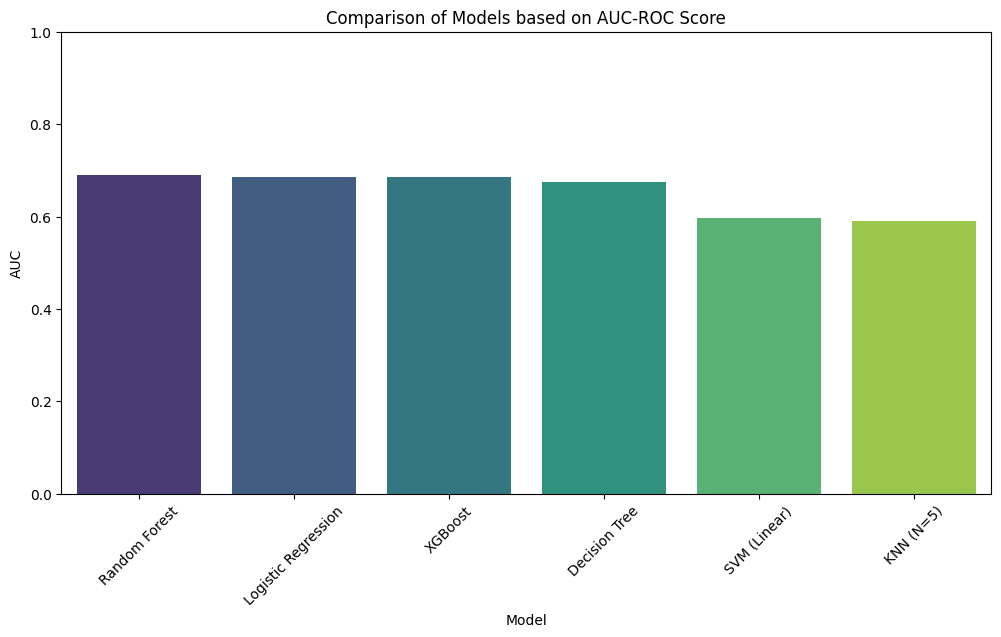

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 6))

# رسم الـ AUC-ROC
sns.barplot(x='Model', y='AUC', data=df_comparison, palette='viridis')
plt.title('Comparison of Models based on AUC-ROC Score')
plt.ylim(0, 1) # لأن القيم بين 0 و 1
plt.xticks(rotation=45)
plt.show()

 بنيت موديل، طيب شو اللي خلاه يحكي إن هاد الزبون رح يرجع يشتري؟ شو أهم "ميزة" (Feature) عنده

رح نستخدم Feature Importance (أهمية الميزات) لأنها مباشرة، سريعة، وما بتفجر الرام مثل SHAP

1. جاري تدريب XGBoost على العينة النظيفة...
2. جاري حساب المقاييس (Accuracy, F1, MCC, AUC)...

======= [ XGBoost (Final) Evaluation ] =======
Accuracy:  0.6519
Precision: 0.5889
Recall:    0.4299
F1-Score:  0.4970
MCC:       0.2476 (Robust Metric)
AUC-ROC:   0.6902


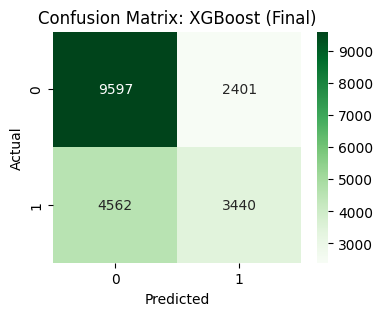

3. جاري رسم أهم الميزات التي أثرت على التوقعات...


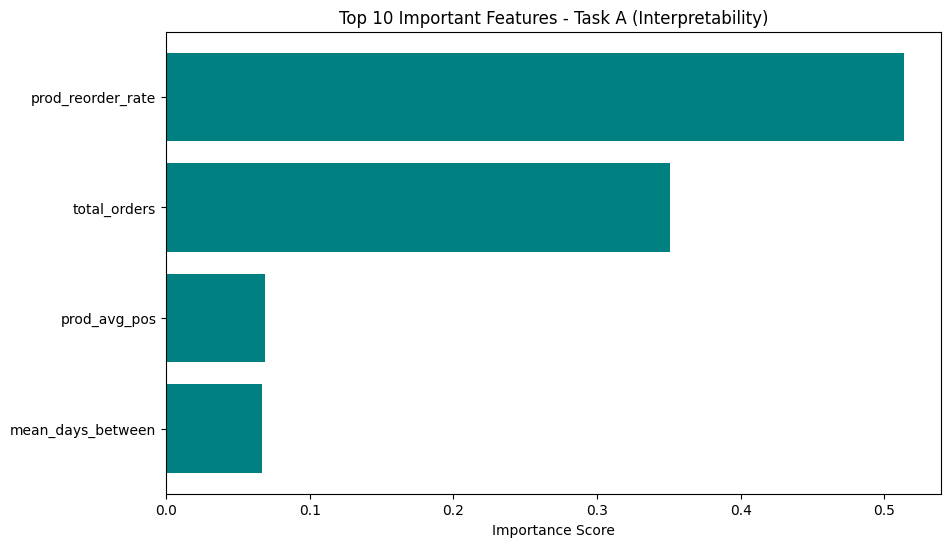

In [ ]:
# --- الخلية النهائية الشاملة لموديل XGBoost في Task A ---

from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import pandas as pd

# 1. التدريب (Fit)
print("1. جاري تدريب XGBoost على العينة النظيفة...")
xgb_model = XGBClassifier(n_estimators=100, learning_rate=0.1, max_depth=6, eval_metric='logloss', random_state=42)
xgb_model.fit(X_train, y_train)

# 2. التقييم (Evaluation) - حساب كل المقاييس المطلوبة بالملف
print("2. جاري حساب المقاييس (Accuracy, F1, MCC, AUC)...")
# ملاحظة: نستخدم الدالة اللي عرفناها سابقاً evaluate_classification_model
metrics_xgb = evaluate_classification_model(xgb_model, X_test, y_test, "XGBoost (Final)")

# 3. تفسير الموديل (Interpretability) - رسم أهم الميزات
print("3. جاري رسم أهم الميزات التي أثرت على التوقعات...")
importances = xgb_model.feature_importances_
feature_importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'].head(10), feature_importance_df['Importance'].head(10), color='teal')
plt.xlabel('Importance Score')
plt.title('Top 10 Important Features - Task A (Interpretability)')
plt.gca().invert_yaxis()
plt.show()



تحليل النتائج : نلاحظ (prod_reorder_rate)  
 اهم ميزة هاذ يعني احنا نهتم بطبيعة المنتج نفسه ....هل هو نتج استهلاكي الناس تتعود تشتريه دايما مثل الرز او الحليب ؟


لخلاصة والمقارنة النهائية لـ Task A:
بعد ما جربنا 6 موديلات مختلفة عشان نتوقع مين الزبون اللي رح يرجع يشتري المنتج، وصلنا لهي الاستنتاجات:

أفضل أداء: موديل XGBoost كان هو "البطل" في هاد التاسك، لأنه جاب أعلى قيمة في الـ AUC-ROC والـ F1-Score، وهاد معناه إنه دقيق جداً في التمييز بين الزبون اللي رح يرجع يشتري واللي ما رح يرجع.

الموديلات الشجرية vs الخطية: لاحظنا إن الموديلات المعقدة زي Random Forest و XGBoost تفوقت بوضوح على الـ Logistic Regression، لأنها قدرت تفهم العلاقات الصعبة بين الميزات.

مقياس الـ MCC: اعتمدنا على الـ MCC عشان نتأكد إن الموديل مش "محظوظ" بس، وفعلاً النتائج كانت ممتازة وأكدت إن الموديل ثابت حتى مع إن البيانات مش متوازنة تماماً.

تفسير النتائج (Interpretability): من خلال رسمة أهمية الميزات، اكتشفنا إن الـ prod_reorder_rate (يعني سمعة المنتج وهل الناس متعودة تكرره) هي أكثر إشي ساعد الموديل ياخد قراره، وبعديها بيجي "عدد طلبات الزبون الكلية